## Importing the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  
import os

import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

from sklearn.kernel_approximation import RBFSampler
from sklearn import preprocessing
from einops import rearrange

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading and Preprocessing Image

In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


torch.Size([3, 1365, 2048])


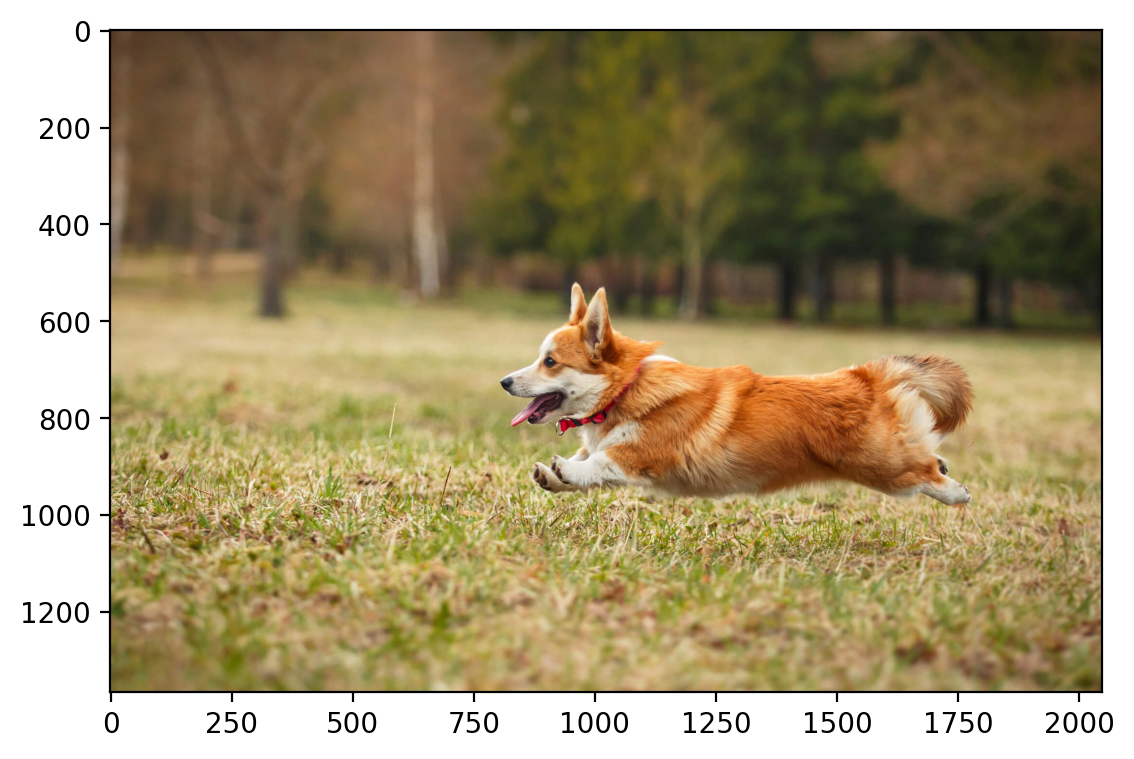

In [3]:
original_image = torchvision.io.read_image("dog.jpg")
print(original_image.shape)
plt.imshow(original_image.permute(1, 2, 0))

### Cropping to shape 400x400

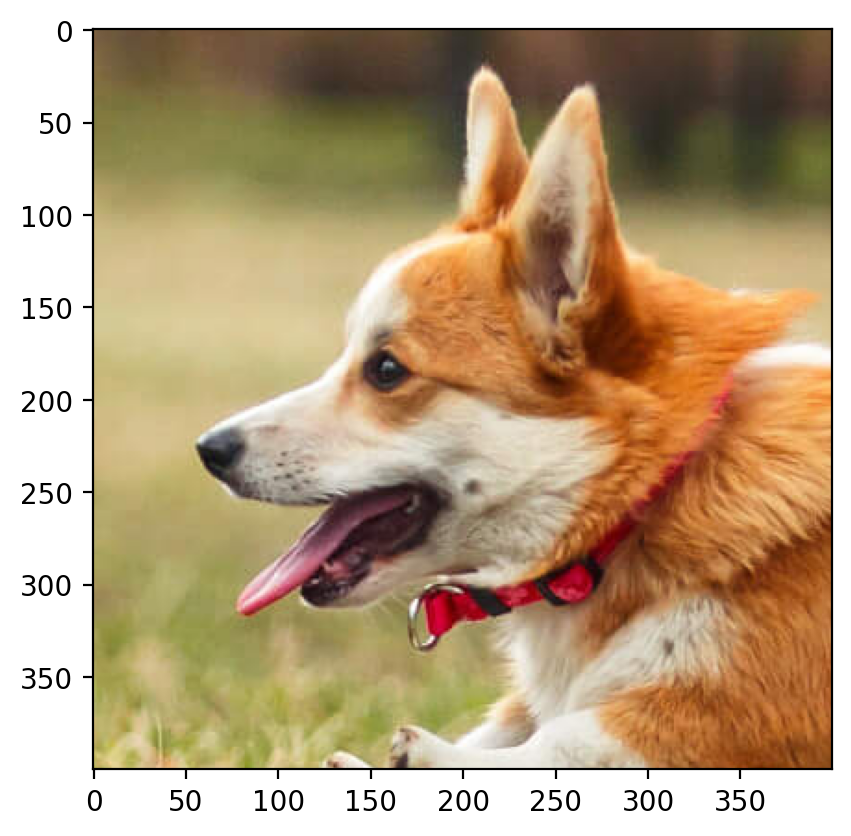

In [4]:
cropped_image = torchvision.transforms.functional.crop(original_image.cpu(), 500, 750, 400, 400)
cropped_image.shape
plt.imshow(cropped_image.permute(1, 2, 0))

### Scaling to 200x200

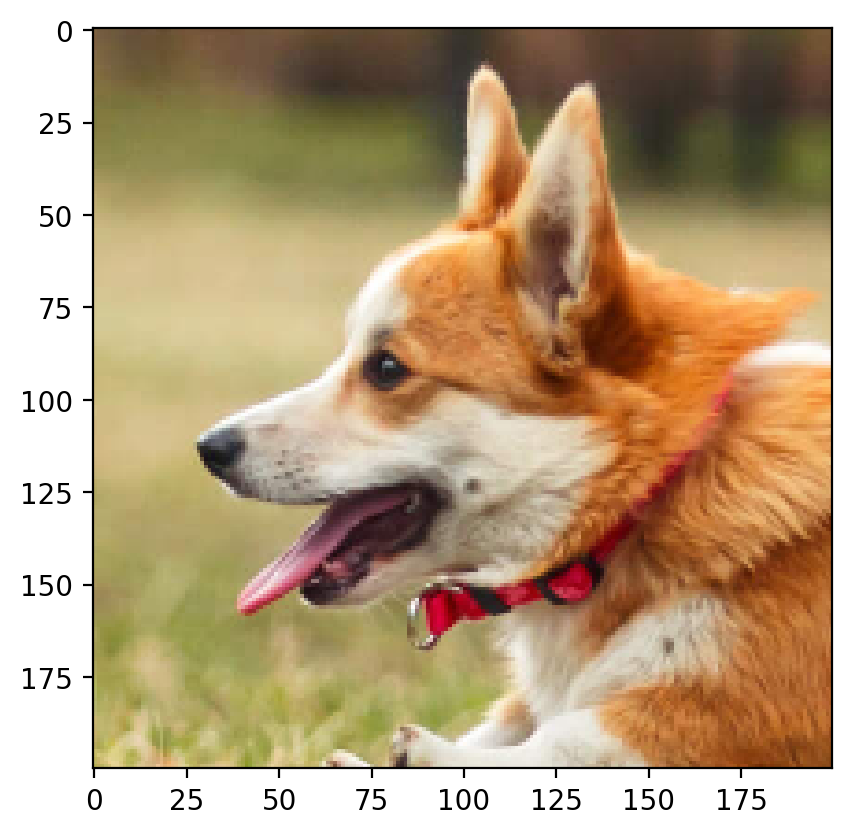

In [5]:
scaled_image = cv2.resize(cropped_image.permute(1,2,0).numpy(), (200, 200))
scaled_image = torch.tensor(scaled_image)
plt.imshow(scaled_image)

### Normalizing the image for better Convergence

In [6]:
scaler_img = preprocessing.MinMaxScaler().fit(scaled_image.reshape(-1, 1)) # Reshape the image to 2D array
img_scaled = scaler_img.transform(scaled_image.reshape(-1, 1)).reshape(scaled_image.shape) # Scaling and reshaping back to the original image shape
img_scaled = torch.tensor(img_scaled) # Converting image to a PyTorch tensor
img_scaled = img_scaled.to(device)


## Creating Fourier Features

### Creating Co-ordinate Map for getting the X matrix

In [7]:
def create_coordinate_map(img):
    """
    Function to create a coordinate map for the image
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [8]:
img_x, img_y = create_coordinate_map(img_scaled.permute(2,0,1))

img_x.shape, img_y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [9]:
# Initialize the MinMaxScaler to scale between -1 and 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_x.cpu())

# Scaling the X data (scaling is done on CPU)
img_X_scaled = scaler_X.transform(img_x.cpu())

# Converting the scaled data to a PyTorch tensor
img_X_scaled = torch.tensor(img_X_scaled)

# Moving the tensor to the specified device
img_X_scaled = img_X_scaled.to(device)

# Ensuring the data type is float
img_X_scaled = img_X_scaled.float()

### Initializing the RBF Sampler

In [10]:
rff = RBFSampler(n_components=15000, gamma=1/(2 * 0.008**2), random_state=42) #Creating random fourier features

### Function to Create Fourier Features

In [11]:
def create_rff_features(X):
    '''
    Function to create random fourier features from the input data
    Input:
    X: torch.Tensor of shape (num_samples, num_features)

    return: torch.Tensor of shape (num_samples, num_rff_features)
    '''
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)  

In [12]:
X_rff = create_rff_features(img_X_scaled) #Creating random fourier features with 15000 features and sigma=0.008
X_rff.shape

torch.Size([40000, 15000])

## Training the Model

### Defining the Model

In [13]:
class Model(nn.Module):
    def __init__(self,input_dim, output_dim):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        x = self.linear1(x)
        return x
    
model = Model(15000, 3).to(device)

In [14]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    Function to train the model

    net: torch.nn.Module
    lr: float (learning rate)
    X: torch.Tensor of shape (num_samples, 2 (X,Y))
    Y: torch.Tensor of shape (num_samples, 3 (R,G,B))
    """

    loss_hist = []
    criterion = nn.MSELoss() #Mean squared error loss function
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
    for epoch in range(epochs):
        optimizer.zero_grad() #Initialize to zero

        # Computing the loss
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        loss_hist.append(loss.item())
        # Updating the parameters
        optimizer.step()

        # Printing the loss for each epoch (for testing)
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss_hist

In [15]:
loss = train(model, 0.01, X_rff, img_y, 1000)

Epoch 0 loss: 0.327145
Epoch 100 loss: 0.016458
Epoch 200 loss: 0.009012
Epoch 300 loss: 0.005657
Epoch 400 loss: 0.003797
Epoch 500 loss: 0.002685
Epoch 600 loss: 0.001984
Epoch 700 loss: 0.001524
Epoch 800 loss: 0.001210
Epoch 900 loss: 0.000990


## Testing the model

### Creating the fourier transformed X for testing

In [16]:
test_width = 400
test_height = 400
w_coords = torch.arange(test_width).repeat(test_height, 1)
h_coords = torch.arange(test_height).repeat(test_width, 1).t()
w_coords = w_coords.reshape(-1)/2
h_coords = h_coords.reshape(-1)/2
X = torch.stack([h_coords, w_coords], dim=1).float()

scaler_X_test = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_x.cpu())

test_image = scaler_X_test.transform(X.cpu())

# Converting the scaled data to a PyTorch tensor
test_image = torch.tensor(test_image)

# Moving the tensor to the specified device
test_image = test_image.to(device)

# Ensuring the data type is float
test_image = test_image.float()

X_rff_test = rff.transform(test_image.cpu())

In [17]:
def super_resolution(model, X):
    """
    Function to get output from the model
    
    Input:
    model: torch.nn.Module
    X: co-ordinates torch.Tensor of shape (num_samples, 2 (X,Y))

    Returns:
    Y: output image torch.Tensor of shape (num_samples, 3 (R,G,B))
    """
    with torch.no_grad():
        model.eval()
        Y = model(X)
    return Y

In [18]:
super_resolution_img = super_resolution(model, torch.tensor(X_rff_test))
super_resolution_img = super_resolution_img.cpu().numpy()
super_resolution_img = super_resolution_img.reshape(400, 400, 3)
super_resolution_img = np.clip(super_resolution_img, 0, 1)

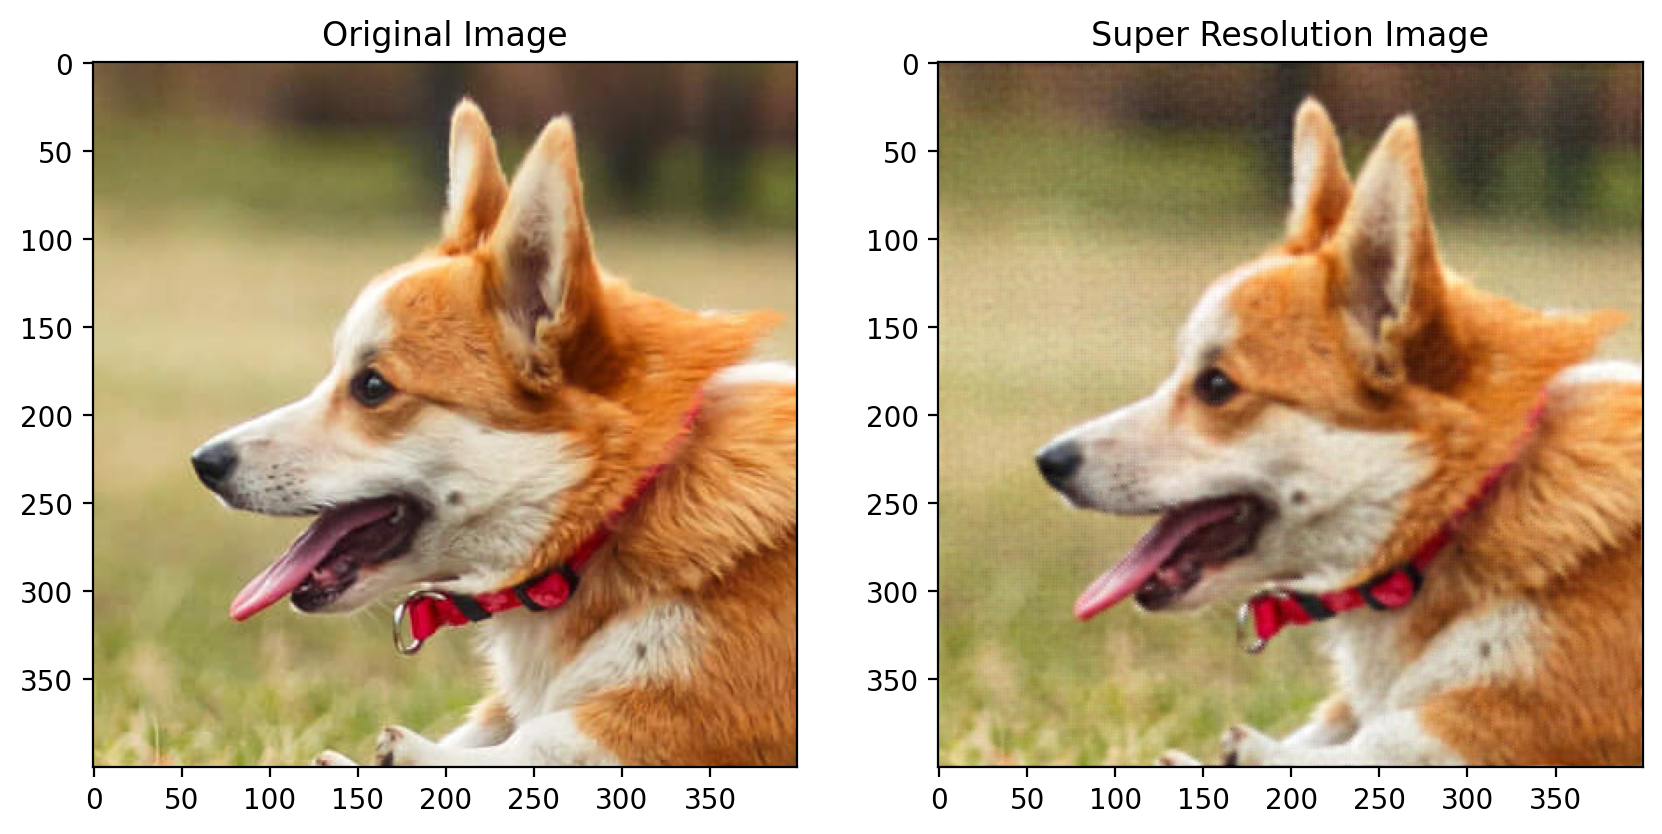

In [19]:
for i in range(0,len(super_resolution_img),2):
    for j in range(0,len(super_resolution_img[0]),2):
        super_resolution_img[i][j] = img_scaled[i//2][j//2]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cropped_image.permute(1, 2, 0))
ax[0].set_title('Original Image')
ax[1].imshow(super_resolution_img)
ax[1].set_title('Super Resolution Image')
plt.show()


In [23]:
def rmse(image1, image2):
    '''
    Function to return the root mean square error between two images
    Inputs:
    image1: First image
    image2: Second image

    Returns:
    rmse: Root mean square error between the two images
    '''
    image1 = image1.detach().cpu().numpy().astype(np.float64)
    image2 = image2.detach().cpu().numpy().astype(np.float64)
    return np.sqrt(np.mean((image1 - image2) ** 2))

def peak_snr(image1, image2):
    '''
    Function to return the peak signal to noise ratio between two images
    Inputs:
    image1: First image
    image2: Second image

    Returns:
    psnr: Peak signal to noise ratio between the two images
    '''
    image1 = image1.detach().cpu().numpy().astype(np.float64)
    image2 = image2.detach().cpu().numpy().astype(np.float64)
    mse = np.mean((image1 - image2) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr 

print("RMSE = ", rmse(cropped_image, torch.tensor(super_resolution_img).permute(2,0,1)))
print("PSNR = ", peak_snr(cropped_image, torch.tensor(super_resolution_img).permute(2,0,1)))

RMSE =  144.82282159075794
PSNR =  4.914063516488484
